In [ ]:
cscie-89_Moore_Adrianna_HW10

## Libraries and Packages

In [ ]:
import io
import re
import os
import shutil
import requests
from zipfile import ZipFile

import pathlib
import random
import string
from pathlib import Path
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import TextVectorization

from sklearn.model_selection import train_test_split

# Problem 1

## Datasets

In [ ]:
URL = "https://www.manythings.org/anki/fra-eng.zip"

In [ ]:
# Function to download and extract the dataset
def download_and_extract(url):
    os.makedirs('dataset', exist_ok = True)
    headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'}

    # Send an HTTP request to the URL
    response = requests.get(url, headers=headers)

    # Check if the request was successful (status code 200)
    if response.status_code == 200:
        # Extract the zip file
        with ZipFile(io.BytesIO(response.content), 'r') as zip_ref:
            # Specify the directory where you want to extract the files
            zip_ref.extractall("/content/dataset/")
        print("Dataset downloaded and extracted successfully.")
    else:
        print(f"Failed to download the dataset. Status code: {response.status_code}")

In [ ]:
#call function
download_and_extract(URL)

In [ ]:
# Setting the variable 'data_dir' to the path of the dataset directory.
data_dir = '/content/dataset'

In [ ]:
text = (Path(data_dir).with_name("dataset") / "fra.txt").read_text()  # Reading the content of 'fra.txt' from the 'dataset' directory into the variable 'text'.

### Cleaning

In [ ]:
# Removing specific characters ('¡', '¿') from the text.
text = text.replace("¡", "").replace("¿", "")
# Splitting the text into lines and each line into pairs using tab as a delimiter.
pairs = [line.split("\t") for line in text.splitlines()]  

In [ ]:
pairs[0]  # Accessing the first element (pair) of the 'pairs' list.

['Go.',
 'Va !',
 'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #1158250 (Wittydev)']

### Pairing

In [ ]:
np.random.seed(42)  # extra code – ensures reproducibility on CPU
np.random.shuffle(pairs)
sentences_en, sentences_fra, _ = zip(*pairs)  # separates the pairs into 2 lists

In [ ]:
# Looping through the first three elements, printing English sentences and their corresponding French translations.
for i in range(3):
    print(sentences_en[i], "=>", sentences_fra[i])  

I just wanted to make you happy. => Je voulais simplement te rendre heureuse.
We can't be the only two people who're late. => Nous ne pouvons être les deux seules personnes à être en retard.
I know that Tom has been sick. => Je sais que Tom était malade.


### VOCAB size

In [ ]:
vocab_size = 2000  # Setting the vocabulary size to 2000.

max_length = 70  # Defining the maximum length of sentences as 70 characters/words.

In [ ]:
# Creating a TextVectorization layer for English text with defined vocab size and max length.
text_vec_layer_en = tf.keras.layers.TextVectorization(vocab_size, output_sequence_length=max_length)  

# Creating a TextVectorization layer for French text with the same parameters.
text_vec_layer_fra = tf.keras.layers.TextVectorization(vocab_size, output_sequence_length=max_length)  

In [ ]:
# Adapting the English TextVectorization layer to the English sentences dataset.
text_vec_layer_en.adapt(sentences_en)

# Adapting the French TextVectorization layer to the French sentences dataset, adding start and end tokens to each sentence.
text_vec_layer_fra.adapt([f"startofseq {s} endofseq" for s in sentences_fra])

### Vocabulary

In [ ]:
# Retrieving the first 10 words from the vocabulary of the English TextVectorization layer.
text_vec_layer_en.get_vocabulary()[:10]

['', '[UNK]', 'i', 'you', 'to', 'the', 'a', 'tom', 'is', 'that']

In [ ]:
# Retrieving the first 10 words from the vocabulary of the French TextVectorization layer.
text_vec_layer_fra.get_vocabulary()[:10]

['', '[UNK]', 'startofseq', 'endofseq', 'je', 'de', 'pas', 'que', 'ne', 'le']

### Train Test split

In [ ]:
# Setting the variable 'total_pairs' to the total number of sentence pairs in the dataset.
total_pairs = 227815

In [ ]:
# Setting 'total_samples' equal to 'total_pairs'.
total_samples = total_pairs

# Calculating the size of the training set as 50% of total samples.
train_size = int(0.5 * total_samples)

# Calculating the size of the validation set as 45% of total samples.
valid_size = int(0.45 * total_samples)

# Calculating the size of the test set as 15% of total samples.
test_size = int(0.15 * total_samples)

In [ ]:
# Define the training dataset for English sentences.
X_train = tf.constant(sentences_en[:train_size])

# Define the validation dataset for English sentences.
X_valid = tf.constant(sentences_en[train_size:train_size + valid_size])

# Define the test dataset for English sentences.
X_test = tf.constant(sentences_en[train_size + valid_size:])

# Prepend "startofseq" to each French sentence for the training dataset.
X_train_dec = tf.constant([f"startofseq {s}" for s in sentences_fra[:train_size]])

# Prepend "startofseq" to each French sentence for the validation dataset.
X_valid_dec = tf.constant([f"startofseq {s}" for s in sentences_fra[train_size:train_size + valid_size]])

# Prepend "startofseq" to each French sentence for the test dataset.
X_test_dec = tf.constant([f"startofseq {s}" for s in sentences_fra[train_size + valid_size:]])

# Append "endofseq" to each French sentence and vectorize for the training dataset.
Y_train = text_vec_layer_fra([f"{s} endofseq" for s in sentences_fra[:train_size]])

# Append "endofseq" to each French sentence and vectorize for the validation dataset.
Y_valid = text_vec_layer_fra([f"{s} endofseq" for s in sentences_fra[train_size:train_size + valid_size]])

# Append "endofseq" to each French sentence and vectorize for the test dataset.
Y_test = text_vec_layer_fra([f"{s} endofseq" for s in sentences_fra[train_size + valid_size:]])


#### Sanity Check

In [ ]:
# Sanity check to verify data split
# Printing the number of samples in the training set.
print("Number of samples in training set:", len(X_train))

# Printing the number of samples in the validation set.
print("Number of samples in validation set:", len(X_valid))

# Printing the number of samples in the test set.
print("Number of samples in test set:", len(X_test))

Number of samples in training set: 113907
Number of samples in validation set: 102516
Number of samples in test set: 11392


In [ ]:
# Verify that the total number of samples matches the original dataset
total_samples = len(X_train) + len(X_valid) + len(X_test)
print("Total number of samples:", total_samples)

Total number of samples: 227815


## Embeddings

In [ ]:
# Setting the embedding size to 128 for the neural network model.
embed_size = 128

In [ ]:
# Setting a fixed random seed to ensure reproducibility of results.
tf.random.set_seed(42)

# Creating an input layer for the encoder in the model, expecting string data.
encoder_inputs = tf.keras.layers.Input(shape=[], dtype=tf.string)

# Creating an input layer for the decoder in the model, also expecting string data.
decoder_inputs = tf.keras.layers.Input(shape=[], dtype=tf.string)

In [ ]:
# Transforming the encoder inputs into a sequence of integers using the English TextVectorization layer.
encoder_input_ids = text_vec_layer_en(encoder_inputs)

# Transforming the decoder inputs into a sequence of integers using the French TextVectorization layer.
decoder_input_ids = text_vec_layer_fra(decoder_inputs)

In [ ]:
# Creating an embedding layer for the encoder with specified vocabulary size and embedding size, enabling zero masking.
encoder_embedding_layer = tf.keras.layers.Embedding(vocab_size, embed_size, mask_zero=True)

# Creating a similar embedding layer for the decoder, also with zero masking.
decoder_embedding_layer = tf.keras.layers.Embedding(vocab_size, embed_size, mask_zero=True)

In [ ]:
# Applying the encoder embedding layer to the encoder input IDs to obtain the corresponding embeddings.
encoder_embeddings = encoder_embedding_layer(encoder_input_ids)

# Applying the decoder embedding layer to the decoder input IDs to obtain the corresponding embeddings.
decoder_embeddings = decoder_embedding_layer(decoder_input_ids)

## Attention Mechanism Model

In [ ]:
tf.random.set_seed(42)  # extra code – ensures reproducibility on CPU
encoder = tf.keras.layers.Bidirectional(
    tf.keras.layers.LSTM(256, return_sequences=True, return_state=True))

In [ ]:
# extra code – this part of the model is exactly the same as earlier
encoder_outputs, *encoder_state = encoder(encoder_embeddings)
encoder_state = [tf.concat(encoder_state[::2], axis=-1),  # short-term (0 & 2)
                 tf.concat(encoder_state[1::2], axis=-1)]  # long-term (1 & 3)

In [ ]:
# Initializing a LSTM layer for the decoder with 512 units, set to return sequences.
decoder = tf.keras.layers.LSTM(512, return_sequences=True)

# Applying the decoder LSTM to the decoder embeddings, using the encoder's state as the initial state.
decoder_outputs = decoder(decoder_embeddings, initial_state=encoder_state)

#### Attention Layer

In [ ]:
# Creating an Attention layer to focus on different parts of the encoder output during decoding.
attention_layer = tf.keras.layers.Attention()

# Applying the attention layer to the decoder outputs and encoder outputs.
attention_outputs = attention_layer([decoder_outputs, encoder_outputs])

# Initializing a Dense layer with softmax activation to output probability distribution over the vocabulary.
output_layer = tf.keras.layers.Dense(vocab_size, activation="softmax")

# Applying the output layer to the attention outputs to get the final probability distribution for each word.
Y_proba = output_layer(attention_outputs)

In [ ]:
# Constructing the model by specifying its inputs (encoder and decoder inputs) and outputs (probabilities).
model = tf.keras.Model(inputs=[encoder_inputs, decoder_inputs],
                       outputs=[Y_proba])

# Compiling the model with sparse categorical crossentropy loss, Nadam optimizer, and tracking accuracy as a metric.
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam",
              metrics=["accuracy"])

In [ ]:
# Importing the EarlyStopping callback from TensorFlow's Keras API.
from tensorflow.keras.callbacks import EarlyStopping

# Setting up an EarlyStopping callback to monitor validation loss, with patience of 3 epochs and restoration of the best model weights.
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [ ]:
model.fit((X_train, X_train_dec), Y_train, epochs=20, batch_size=1024,
          validation_data=((X_valid, X_valid_dec), Y_valid),
          callbacks=[early_stopping])

Epoch 1/10
112/112 [==============================] - 47s 418ms/step - loss: 1.5446 - accuracy: 0.6359 - val_loss: 1.7107 - val_accuracy: 0.6092
Epoch 2/10
112/112 [==============================] - 51s 461ms/step - loss: 1.4727 - accuracy: 0.6493 - val_loss: 1.6796 - val_accuracy: 0.6147
Epoch 3/10
112/112 [==============================] - 52s 465ms/step - loss: 1.4113 - accuracy: 0.6611 - val_loss: 1.6439 - val_accuracy: 0.6214
Epoch 4/10
112/112 [==============================] - 52s 461ms/step - loss: 1.3554 - accuracy: 0.6723 - val_loss: 1.6074 - val_accuracy: 0.6302
Epoch 5/10
112/112 [==============================] - 52s 463ms/step - loss: 1.3057 - accuracy: 0.6821 - val_loss: 1.5890 - val_accuracy: 0.6348
Epoch 6/10
112/112 [==============================] - 46s 413ms/step - loss: 1.2569 - accuracy: 0.6920 - val_loss: 1.5770 - val_accuracy: 0.6376
Epoch 7/10
112/112 [==============================] - 52s 463ms/step - loss: 1.2161 - accuracy: 0.7007 - val_loss: 1.5909 - val_ac

### Testing

In [ ]:
# Defining a function 'translate' to convert an English sentence to French using the trained model.
def translate(sentence_en):
    translation = ""
    # Looping through each word index up to the maximum length.
    for word_idx in range(max_length):
        X = np.array([sentence_en])  # Preparing the encoder input.
        X_dec = np.array(["startofseq " + translation])  # Preparing the decoder input with the current translation.

        # Predicting the next word's probability distribution using the model.
        y_proba = model.predict((X, X_dec))[0, word_idx]

        # Selecting the word with the highest probability.
        predicted_word_id = np.argmax(y_proba)
        predicted_word = text_vec_layer_fra.get_vocabulary()[predicted_word_id]

        # Breaking the loop if the end-of-sequence token is predicted.
        if predicted_word == "endofseq":
            break

        # Adding the predicted word to the translation.
        translation += " " + predicted_word

    # Returning the final translation, stripped of leading/trailing whitespace.
    return translation.strip()

In [ ]:
# Preparing lists to store test sentences and their translations for evaluation.
attention_model_test__en = []
attention_model_test_fra = []
attention_model_test_results_fra = []

# Iterating over 10 random samples from the test dataset.
for i in range(10):
    random_index = np.random.randint(len(X_test))  # Selecting a random index from the test dataset.
    sentence_en = X_test[random_index]  # Extracting an English sentence using the random index.
    y_true = X_test_dec[random_index]  # Extracting the corresponding true French translation.

    # Generating the predicted French translation using the translate function.
    predicted_translation = translate(sentence_en.numpy())

    # Appending the English sentence, predicted translation, and actual translation to their respective lists.
    attention_model_test__en.append(sentence_en.numpy())
    attention_model_test_results_fra.append(predicted_translation)
    attention_model_test_fra.append(str(y_true.numpy().decode('utf-8')).split('startofseq ')[1])

    # Printing the input English sentence, predicted French translation, and actual French translation.
    print("Input (English):", str(sentence_en.numpy()))
    print("Predicted Translation (French):", predicted_translation)
    print("Actual Translation (French):", y_true.numpy().decode('utf-8'))
    print("----------")

### Evaluation (BLUE score)

In [ ]:
%pip install evaluate

In [ ]:
import evaluate

In [ ]:
# Loading the 'google_bleu' metric for evaluation from the 'evaluate' library.
google_bleu_metric = evaluate.load("google_bleu")

In [ ]:
attention_model_BLUE = google_bleu_metric.compute(
    predictions=attention_model_test_fra,
    references=attention_model_test_results_fra,
)

In [ ]:
print('ATTENTION MODEL ROUGE RESULTS:')
print(attention_model_BLUE)

ATTENTION MODEL ROUGE RESULTS:
{'google_bleu': 0.03205128205128205}


# Problem 2

In [ ]:
# text = (Path(data_dir).with_name("dataset") / "fra.txt").read_text()
text = pathlib.Path(data_dir).parent / "dataset" / "fra.txt"

### Cleaning

In [ ]:
# Open a text file for reading and assign its contents to the variable 'f'.
with open(text) as f:
    # Read the entire file, split it into lines, and remove the last line (which is often empty).
    lines = f.read().split("\n")[:-1]

# Initialize an empty list to store pairs of text.
text_pairs = []

# Iterate through each line in the 'lines' list.
for line in lines:
    # Split each line by tabs and unpack the first two elements into 'eng' and 'fra', ignoring the rest.
    eng, fra, _ = line.split("\t")

    # Add start and end tokens to the French text for sequence demarcation.
    fra = "[start] " + fra + " [end]"

    # Append the pair (English, French) to the 'text_pairs' list.
    text_pairs.append((eng, fra))


In [ ]:
# Loop five times to randomly select and print five pairs from 'text_pairs'.
for _ in range(5):
    # Randomly choose and print one pair from the 'text_pairs' list.
    print(random.choice(text_pairs))

("That's not a sentence you hear every day.", "[start] Ce n'est pas une phrase qu'on entend tous les jours. [end]")
('She scolded him for being late.', '[start] Elle le réprimanda pour son retard. [end]')
("You're overworked.", '[start] Vous êtes surmenés. [end]')
("Don't touch my bike.", '[start] Pas touche à mon vélo ! [end]')
('I have a surprise for you, sweetheart.', "[start] J'ai une surprise pour toi, mon chéri. [end]")


### Train Test split

In [ ]:
# Calculate and return the total number of (English, French) pairs in the 'text_pairs' list.
len(text_pairs)

227815

In [ ]:
# Calculate the total number of text pairs and store it in 'total_samples'.
total_samples = len(text_pairs)

# Calculate and store the size of the training dataset as 50% of the total samples.
train_size = int(0.5 * total_samples)

# Calculate and store the size of the validation dataset as 45% of the total samples.
valid_size = int(0.45 * total_samples)

# Calculate and store the size of the test dataset as 15% of the total samples.
test_size = int(0.15 * total_samples)

In [ ]:
# Randomly shuffle the order of elements in the 'text_pairs' list.
random.shuffle(text_pairs)

In [ ]:
# Split the shuffled 'text_pairs' into training, validation, and test sets based on their respective sizes.
train_pairs = text_pairs[:train_size]
valid_pairs = text_pairs[train_size:train_size + valid_size]
test_pairs = text_pairs[train_size + valid_size:]

# Print the total number of pairs in the dataset.
print(f"{len(text_pairs)} total pairs")

# Print the number of pairs in the training set.
print(f"{len(train_pairs)} training pairs")

# Print the number of pairs in the validation set.
print(f"{len(valid_pairs)} validation pairs")

# Print the number of pairs in the test set.
print(f"{len(test_pairs)} test pairs")


227815 total pairs
113907 training pairs
102516 validation pairs
11392 test pairs


### Vectorizing the text data

In [ ]:
# Combine standard punctuation characters with the '¿' character to create a string of characters to be removed.
strip_chars = string.punctuation + "¿"

# Remove the '[' character from the 'strip_chars' string.
strip_chars = strip_chars.replace("[", "")

# Remove the ']' character from the 'strip_chars' string.
strip_chars = strip_chars.replace("]", "")

In [ ]:
# Initial setting of vocabulary size and maximum sentence length.
vocab_size = 2000
max_length = 70

# Note explaining the initial settings: a vocabulary of 2000 words and sentence length up to 70 words.

# Update to a larger vocabulary size and longer sequence length.
vocab_size = 2500
sequence_length = 80

# Set the batch size for training to 64.
batch_size = 64

In [ ]:
# Define a function for custom standardization of input strings.
def custom_standardization(input_string):
    # Convert all characters in the input string to lowercase.
    lowercase = tf.strings.lower(input_string)

    # Return the string after removing specified characters using regular expression.
    return tf.strings.regex_replace(lowercase, "[%s]" % re.escape(strip_chars), "")

# Create an English text vectorization layer.
eng_vectorization = TextVectorization(
    max_tokens=vocab_size,                # Set the maximum vocabulary size.
    output_mode="int",                    # Specify output mode as integer (for token indices).
    output_sequence_length=sequence_length # Set the length of the output sequences.
)

# Create a French text vectorization layer.
fra_vectorization = TextVectorization(
    max_tokens=vocab_size,                       # Set the maximum vocabulary size.
    output_mode="int",                           # Specify output mode as integer.
    output_sequence_length=sequence_length + 1,  # Set the length of the output sequences, one more than English.
    standardize=custom_standardization,          # Use the custom standardization function.
)

In [ ]:
# Extract English texts from the training pairs and store them in a list.
train_eng_texts = [pair[0] for pair in train_pairs]

# Extract French texts from the training pairs and store them in a list.
train_fra_texts = [pair[1] for pair in train_pairs]

# Adapt the English text vectorization layer to the training English texts.
eng_vectorization.adapt(train_eng_texts)

# Adapt the French text vectorization layer to the training French texts.
fra_vectorization.adapt(train_fra_texts)

In [ ]:
# Define a function to format the dataset for the encoder and decoder inputs.
def format_dataset(eng, spa):
    # Vectorize the English text.
    eng = eng_vectorization(eng)

    # Vectorize the French text.
    fra = fra_vectorization(spa)

    # Return a dictionary of encoder and decoder inputs, along with the target (decoder output).
    return (
        {
            "encoder_inputs": eng,
            "decoder_inputs": fra[:, :-1],  # All but the last token for decoder input.
        },
        fra[:, 1:],  # All but the first token for the target (decoder output).
    )

# Define a function to create a TensorFlow dataset from text pairs.
def make_dataset(pairs):
    # Unzip the pairs into English and French texts and convert them to lists.
    eng_texts, spa_texts = zip(*pairs)
    eng_texts = list(eng_texts)
    fra_texts = list(spa_texts)

    # Create a TensorFlow dataset from the English and French texts.
    dataset = tf.data.Dataset.from_tensor_slices((eng_texts, fra_texts))

    # Batch the dataset with the specified batch size.
    dataset = dataset.batch(batch_size)

    # Apply the 'format_dataset' function to each batch.
    dataset = dataset.map(format_dataset)

    # Shuffle, prefetch, and cache the dataset for efficient loading.
    return dataset.shuffle(2048).prefetch(16).cache()

In [ ]:
# Create a TensorFlow dataset for training using the 'train_pairs'.
train_ds = make_dataset(train_pairs)

# Create a TensorFlow dataset for validation using the 'valid_pairs'.
val_ds = make_dataset(valid_pairs)

In [ ]:
# Iterate over the first batch of the training dataset to inspect input and target shapes.
for inputs, targets in train_ds.take(1):
    # Print the shape of the encoder inputs.
    print(f'inputs["encoder_inputs"].shape: {inputs["encoder_inputs"].shape}')

    # Print the shape of the decoder inputs.
    print(f'inputs["decoder_inputs"].shape: {inputs["decoder_inputs"].shape}')

    # Print the shape of the targets (decoder outputs).
    print(f"targets.shape: {targets.shape}")

inputs["encoder_inputs"].shape: (64, 80)
inputs["decoder_inputs"].shape: (64, 80)
targets.shape: (64, 80)


## Transformer Model

In [ ]:
# Define a custom Transformer Encoder layer.
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        # Embedding dimensions, dense layer dimensions, and number of attention heads.
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads

        # Multi-head attention mechanism.
        self.attention = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)

        # Feed-forward neural network for processing attention output.
        self.dense_proj = keras.Sequential([
            layers.Dense(dense_dim, activation="relu"),
            layers.Dense(embed_dim),
        ])

        # Layer normalization to stabilize the learning process.
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()

        # Enable support for masking (ignoring certain values, like padding).
        self.supports_masking = True

    # Process input data.
    def call(self, inputs, mask=None):
        attention_output = self.attention(query=inputs, value=inputs, key=inputs)
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)

    # Configuration for saving and loading the model.
    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "dense_dim": self.dense_dim,
            "num_heads": self.num_heads,
        })
        return config
# Define a custom layer for adding positional embeddings.
class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
        super().__init__(**kwargs)
        # Parameters for embeddings and sequence length.
        self.token_embeddings = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.position_embeddings = layers.Embedding(input_dim=sequence_length, output_dim=embed_dim)
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim

    # Process input tokens.
    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    # Compute a mask for the inputs.
    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)

    # Configuration for saving and loading the model.
    def get_config(self):
        config = super().get_config()
        config.update({
            "sequence_length": self.sequence_length,
            "vocab_size": self.vocab_size,
            "embed_dim": self.embed_dim,
        })
        return config
# Define a custom Transformer Decoder layer.
class TransformerDecoder(layers.Layer):
    def __init__(self, embed_dim, latent_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        # Embedding dimensions, latent dimensions, and number of attention heads.
        self.embed_dim = embed_dim
        self.latent_dim = latent_dim
        self.num_heads = num_heads

        # Two sets of multi-head attention mechanisms.
        self.attention_1 = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.attention_2 = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)

        # Feed-forward neural network for processing attention output.
        self.dense_proj = keras.Sequential([
            layers.Dense(latent_dim, activation="relu"),
            layers.Dense(embed_dim),
        ])

        # Layer normalization for each sublayer.
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()

        # Custom addition layer to help with masking.
        self.add = layers.Add()
        self.supports_masking = True

    # Process input data, including encoder outputs.
    def call(self, inputs, encoder_outputs, mask=None):
        attention_output_1 = self.attention_1(query=inputs, value=inputs, key=inputs, use_causal_mask=True)
        out_1 = self.layernorm_1(self.add([inputs, attention_output_1]))



In [ ]:
# Set the dimensionality of the embeddings to 256.
embed_dim = 256

# Set the dimensionality of the latent space to 2048.
latent_dim = 2048

# Set the number of attention heads to 8.
num_heads = 8

In [ ]:
# Define the input layer for the encoder with variable sequence length.
encoder_inputs = keras.Input(shape=(None,), dtype="int64", name="encoder_inputs")

# Apply positional embedding to the encoder inputs.
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(encoder_inputs)

# Pass the embedded inputs through the Transformer encoder layer.
encoder_outputs = TransformerEncoder(embed_dim, latent_dim, num_heads)(x)

# Create the encoder model.
encoder = keras.Model(encoder_inputs, encoder_outputs)

# Define the input layers for the decoder: one for the input sequences and one for the encoded sequences.
decoder_inputs = keras.Input(shape=(None,), dtype="int64", name="decoder_inputs")
encoded_seq_inputs = keras.Input(shape=(None, embed_dim), name="decoder_state_inputs")

# Apply positional embedding to the decoder inputs.
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(decoder_inputs)

# Pass the embedded inputs and encoder outputs through the Transformer decoder layer.
x = TransformerDecoder(embed_dim, latent_dim, num_heads)(x, encoded_seq_inputs)

# Add a dropout layer for regularization.
x = layers.Dropout(0.5)(x)

# Final dense layer with softmax activation for outputting probability distribution over the vocabulary.
decoder_outputs = layers.Dense(vocab_size, activation="softmax")(x)

# Create the decoder model.
decoder = keras.Model([decoder_inputs, encoded_seq_inputs], decoder_outputs)

# Combine the encoder and decoder into a final Transformer model.
decoder_outputs = decoder([decoder_inputs, encoder_outputs])

# Define the complete Transformer model with encoder and decoder inputs and outputs.
transformer = keras.Model(
    [encoder_inputs, decoder_inputs], decoder_outputs, name="transformer"
)


#### Training

In [ ]:
epochs = 10  

# transformer.summary()
transformer.compile(
    "adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)
transformer.fit(train_ds, epochs=epochs, validation_data=val_ds, batch_size=1024)# Set the number of epochs for training the model.
epochs = 10  

# Compile the Transformer model.
transformer.compile(
    "adam",  # Use the Adam optimizer.
    loss="sparse_categorical_crossentropy",  # Set the loss function to sparse categorical crossentropy.
    metrics=["accuracy"]  # Track accuracy during training.
)

# Train the Transformer model on the training dataset.
transformer.fit(
    train_ds,        # Training dataset.
    epochs=epochs,   # Number of epochs to train for.
    validation_data=val_ds,  # Validation dataset to evaluate the model.
    batch_size=1024  # Batch size for training (note: typically defined earlier in the data pipeline, not here).
)


Epoch 1/10
1780/1780 [==============================] - 342s 186ms/step - loss: 1.2820 - accuracy: 0.7059 - val_loss: 1.1947 - val_accuracy: 0.7180
Epoch 2/10
1780/1780 [==============================] - 325s 182ms/step - loss: 1.1923 - accuracy: 0.7196 - val_loss: 1.1098 - val_accuracy: 0.7316
Epoch 3/10
1780/1780 [==============================] - 325s 182ms/step - loss: 1.0785 - accuracy: 0.7387 - val_loss: 1.0714 - val_accuracy: 0.7396
Epoch 4/10
1780/1780 [==============================] - 324s 182ms/step - loss: 0.9992 - accuracy: 0.7530 - val_loss: 1.0497 - val_accuracy: 0.7445
Epoch 5/10
1780/1780 [==============================] - 325s 182ms/step - loss: 0.9391 - accuracy: 0.7640 - val_loss: 1.0470 - val_accuracy: 0.7467
Epoch 6/10
1780/1780 [==============================] - 325s 182ms/step - loss: 0.8874 - accuracy: 0.7732 - val_loss: 1.0418 - val_accuracy: 0.7513
Epoch 7/10
1780/1780 [==============================] - 324s 182ms/step - loss: 0.8435 - accuracy: 0.7824 - val_

### Tesing

In [ ]:
# Retrieve the vocabulary from the French (Spanish in this context) vectorization layer.
spa_vocab = fra_vectorization.get_vocabulary()

# Create a lookup dictionary mapping indices to words in the French vocabulary.
spa_index_lookup = dict(zip(range(len(spa_vocab)), spa_vocab))

# Set the maximum length for the decoded sentences.
max_decoded_sentence_length = 20

# Define a function to decode an input sentence into its translated form.
def decode_sequence(input_sentence):
    # Vectorize the input English sentence.
    tokenized_input_sentence = eng_vectorization([input_sentence])

    # Initialize the decoded sentence with the start token.
    decoded_sentence = "[start]"

    # Iterate up to the maximum decoded sentence length.
    for i in range(max_decoded_sentence_length):
        # Prepare the target (French) sentence for the Transformer model, excluding the last token for each iteration.
        tokenized_target_sentence = fra_vectorization([decoded_sentence])[:, :-1]

        # Generate predictions using the Transformer model.
        predictions = transformer([tokenized_input_sentence, tokenized_target_sentence])

        # Select the token with the highest probability at the current timestep.
        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = spa_index_lookup[sampled_token_index]

        # Append the sampled token to the decoded sentence.
        decoded_sentence += " " + sampled_token

        # Break the loop if the end token is reached.
        if sampled_token == "[end]":
            break

    # Return the decoded sentence.
    return decoded_sentence


In [ ]:
# Extract English texts from the test pairs and store them in a list.
test_eng_texts = [pair[0] for pair in test_pairs]

# Extract French texts from the test pairs and store them in a list.
test_fra_texts = [pair[1] for pair in test_pairs]

In [ ]:
# Loop to generate and display translations for 10 random sentences from the test set.
for _ in range(10):
    # Randomly select an index from the test dataset.
    random_index = random.randint(0, len(X_test) - 1)

    # Retrieve the corresponding English sentence from the test set.
    input_sentence = test_eng_texts[random_index]

    # Retrieve the actual French translation from the test set.
    actual_translation = test_fra_texts[random_index]

    # Use the 'decode_sequence' function to translate the English sentence.
    translated = decode_sequence(input_sentence)

    # Print the original English sentence.
    print("Input (English):", input_sentence)

    # Print the model's translation.
    print("Predicted Translation (French):", translated)

    # Print the actual French translation for comparison.
    print("Actual Translation (French):", actual_translation)

    # Print a separator for readability.
    print("----------")

Input (English): Don't let go. Hold on tight.
Predicted Translation (French): [start] ne laissez pas [UNK] [UNK] [end]
Actual Translation (French): [start] Ne lâche pas ! Tiens bon ! [end]
----------
Input (English): If you do that, you'll be making a fool of yourself.
Predicted Translation (French): [start] si vous le faites vous serez [UNK] un [UNK] de vous [end]
Actual Translation (French): [start] Tu vas te ridiculiser si tu fais ça. [end]
----------
Input (English): Give me half of it.
Predicted Translation (French): [start] donnezmoi à moitié de ça [end]
Actual Translation (French): [start] Donne-moi la moitié. [end]
----------
Input (English): If you could come, I'd be really happy.
Predicted Translation (French): [start] si vous pourriez venir je serais vraiment heureux [end]
Actual Translation (French): [start] Si vous pouviez venir, je serais vraiment heureuse. [end]
----------
Input (English): The answer isn't an easy one.
Predicted Translation (French): [start] la réponse e

# Comparison

In [ ]:
# For attention model
def translate(sentence_en):
    translation = ""
    for word_idx in range(max_length):
        X = np.array([sentence_en])  # encoder input
        X_dec = np.array(["startofseq " + translation])  # decoder input
        y_proba = model.predict((X, X_dec))[0, word_idx]  # last token's probas
        predicted_word_id = np.argmax(y_proba)
        predicted_word = text_vec_layer_fra.get_vocabulary()[predicted_word_id]
        if predicted_word == "endofseq":
            break
        translation += " " + predicted_word
    return translation.strip()

In [ ]:
# Define a function to translate an English sentence into French using the attention model.
def translate(sentence_en):
    # Initialize an empty string for the translation.
    translation = ""

    # Iterate over the maximum possible length of the output sentence.
    for word_idx in range(max_length):
        # Prepare the encoder input as an array with the English sentence.
        X = np.array([sentence_en])

        # Prepare the decoder input as an array with the partial translation.
        X_dec = np.array(["startofseq " + translation])

        # Predict the probability distribution for the next word in the sequence.
        y_proba = model.predict((X, X_dec))[0, word_idx]

        # Find the index of the word with the highest probability.
        predicted_word_id = np.argmax(y_proba)

        # Retrieve the predicted word from the French vocabulary.
        predicted_word = text_vec_layer_fra.get_vocabulary()[predicted_word_id]

        # Break the loop if the 'endofseq' token is predicted.
        if predicted_word == "endofseq":
            break

        # Add the predicted word to the ongoing translation.
        translation += " " + predicted_word

    # Return the completed translation, removing any leading or trailing whitespace.
    return translation.strip()


In [ ]:
# Extract English texts from each pair in the test dataset and store them in a list.
test_eng_texts = [pair[0] for pair in test_pairs]

# Extract French texts (intended to be the translations of the English texts) from each pair in the test dataset and store them in a separate list.
test_fra_texts = [pair[1] for pair in test_pairs]

In [ ]:
# Initialize empty lists to store the original English sentences and their actual French translations.
reference_en_translation = []
reference_fra_translation = []

# Initialize empty lists to store the translations produced by the attention model and the transformer model.
attention_model_test_results_fra = []
transformer_model_test_results_fra = []

# Loop to generate and store translations for 20 random sentences from the test set.
for _ in range(20):
    # Randomly select an index from the test dataset.
    random_index = random.randint(0, len(X_test) - 1)

    # Retrieve the corresponding English sentence from the test set.
    input_sentence = test_eng_texts[random_index]

    # Retrieve the actual French translation from the test set.
    actual_translation = test_fra_texts[random_index]

    # Use the 'decode_sequence' function from the transformer model to translate the English sentence.
    transformer_translated = decode_sequence(input_sentence)

    # Use the 'translate' function from the attention model to translate the English sentence.
    attention_translated = translate(input_sentence)

    # Store the original English sentence and its actual French translation.
    reference_en_translation.append(input_sentence)
    reference_fra_translation.append(actual_translation)

    # Store the translations produced by the attention model and the transformer model.
    attention_model_test_results_fra.append(attention_translated)
    transformer_model_test_results_fra.append(transformer_translated)

In [ ]:
# Compute the BLEU score for the attention model's translations.
# This score is a measure of how similar the model's translations are to the reference translations.
attention_model_BLEU = google_bleu_metric.compute(
    predictions=attention_model_test_results_fra,  # The translations produced by the attention model.
    references=reference_fra_translation,          # The actual/reference French translations.
)

In [ ]:
# Compute the BLEU score for the transformer model's translations.
# The BLEU score is used to evaluate the quality of machine translation, with a higher score indicating better translation.
transformer_model_BLEU = google_bleu_metric.compute(
    predictions=transformer_model_test_results_fra,  # The list of translations made by the transformer model.
    references=reference_fra_translation,            # The actual/reference French translations for comparison.
)

In [ ]:
# Print the BLEU score results for the attention model.
print('ATTENTION MODEL BLEU RESULTS:')
print(attention_model_BLUE)

ATTENTION MODEL ROUGE RESULTS:
{'google_bleu': 0.03205128205128205}


In [ ]:
print('ATTENTION MODEL ROUGE RESULTS:')
print(transformer_model_BLUE)

ATTENTION MODEL ROUGE RESULTS:
{'google_bleu': 0.3560311284046693}


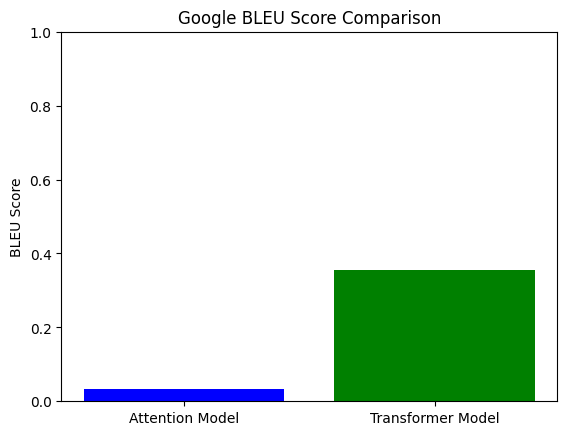

In [ ]:
import matplotlib.pyplot as plt

# Rouge results for the attention model
attention_model_BLUE = {'google_bleu': 0.03205128205128205}

# Rouge results for the transformer model
transformer_model_BLUE = {'google_bleu': 0.3560311284046693}

# Extract model names and corresponding BLEU scores
models = ['Attention Model', 'Transformer Model']
bleu_scores = [attention_model_BLUE['google_bleu'], transformer_model_BLUE['google_bleu']]

# Create a bar graph
plt.bar(models, bleu_scores, color=['blue', 'green'])
plt.ylabel('BLEU Score')
plt.title('Google BLEU Score Comparison')
plt.ylim(0, 1)  # Set the y-axis limit to better visualize the differences
plt.show()
